# Robot Intelligence 1: Cross-Entropy Method



Suppose that we have a "black-box" function $f: \mathcal{X} \mapsto \mathcal{Y}$. We don't know anything about the properties of $f$ (i.e. whether its differentiable, continuous, etc.). However, we *can* query it, i.e. evaluate $f(\cdot)$ for values $x \in \mathcal{X}$.

Let's say we want to model $f(\cdot)$ via a "proxy" function $\hat{f}(\cdot | \theta)$, which depends on some vector of parameters $\theta \in \Theta$. Our goal is to find a set of values $\hat{\theta} \in \Theta$ such that $\hat{f}(\cdot | \hat{\theta})$ is a good proxy (i.e. "model") for $f$. 

## Derivative Free Optimization

How can we go about estimating $\hat{\theta}$? We can break possible approaches across two classes:

1. **derivative-based** optimization methods (DBO); and
2. **derivative-free** optimization (DFO) methods.

These two classes are exactly what they sound like: *derivative-based* methods rely on exact derivatives or derivative estimates, while *derivative-free* methods forego derivatives entirely. 

In our case, our target function $f$ is a "black-box," and may not be differentiable, so we must rely on a DFO method to find a vector $\hat{\theta}$ that yields a "good" proxy $\hat{f}$.

At each iteration $i$ of any DFO method:
* We'll have some candidate value(s) of $\theta$, $\theta_i$.

* Next, we'll compute some measure of "how good" of a proxy the function $\hat{f}(\cdot | \theta_i)$ is for $f(\cdot)$ by either: (1) re-querying $f(\cdot)$ across some a set of points $x \in \mathcal{X}$; or (2) by using a fixed dataset $\mathcal{D}$ of queries $(x, y) \in \mathcal{X} \times \mathcal{Y}$ to $f(\cdot)$.

* Finally, we'll use our computed measures of "goodness" to revise our candidate values(s) in some way, yielding $\theta_{(i + 1)}$.

This process repeats until we are satisfied with $\hat{f}(\cdot | \theta_i)$.


## Cross-Entropy Method (CEM)

The cross-entropy method is a very simple DFO method for policy optimization. Below is a sketch.

* We select some distribution from which to sample values $\theta$, often a multinomial Gaussian. We'll use multinomial Gaussians as our basis for CEM in this tutorial.
* At each iteration $i$, we'll maintain a mean vector $\vec{\mu}_i$ and a covariance matrix $\Sigma_i$. 
* We'll then sample a batch of $N$ parameter vectors $\vec{\theta}$ from the distribution $\mathcal{N}(\vec{\mu}_i, \Sigma_i)$, $B_i = \{\theta \sim \mathcal{N}(\vec{\mu}_i, \Sigma_i): k \in \{1, \dots, N\} \}$.
* Next, we'll compute a measure of "goodness" for each sampled parameter vector $\vec{\theta}$.
* Finally, we update $\vec{\mu}_i$ and $\Sigma_i$ to reflect the top $(M/N)$-fraction of samples in our batch $B_i$, yielding $\vec{\mu}_{i+1}$ and $\Sigma_{i+1}$.

## Part 1: Linear Regression with CEM

Suppose that we have the same data as earlier, in our exploration of `scipy.linalg`.

In [17]:
import numpy as np
from scipy import linalg

In [6]:
x = np.array([[1, 2.5, 3.5, 4, 5, 7, 8.5]])
y = np.array([[0.3, 1.1, 1.5, 2.0, 3.2, 6.6, 8.6]])

We want to find a vector of parameters $\vec{\theta} = [m, b]$ such that $\sqrt{\sum_{(x, y) \in \mathcal{D}}((m * x + b) - y)^2)}$, i.e. the Frobenius norm of all residuals given our data, is minimized. Of course, the obvious way to do this is with simple linear least-squares regression. However, we'll see that we can compute a pretty good estimate for $\theta$ after just a few iterations of CEM!

Let's use a multivariate Gaussian with diagonal covariance matrix to sample candidate values of $m$ and $b$, i.e.

\begin{align}\vec{\theta} \sim \mathcal{N}\left(\begin{bmatrix} \mu_m \\ \mu_b \end{bmatrix}, \begin{bmatrix} \sigma^2_m & 0\\ 0 & \sigma^2_b \end{bmatrix}\right)\end{align}

Write a function that uses `numpy` to produce an array of size `(batch_size,)` of independent samples drawn from a multivariate Gaussian distribution with mean given by a (2, 1)-size vector `means`, and a diagonal covariance matrix with diagonal values given by a (2, 1)-size vector `diag_vars`.

In [7]:
def get_candidate_theta_batch(means, diag_vars, batch_size):
  """"
  Returns an array of size `(batch_size, 2)` filled with independent samples of
  theta drawn from a multivariate Gaussian with mean vector `means` and 
  diagnonal covariance matrix with diagonal vector `diag_vars`.
  """
  return np.random.multivariate_normal(means, np.diag(diag_vars), size=(batch_size,))

Now, write a function that computes a `(batch_size,)` vector of norms given the data vectors `x`, `y` for a size `(batch_size,)` array of samples of $\vec{\theta}$. 

**Your implementation should contain no `for` loops** and should rely on numpy broadcasting instead.

You may use `np.linalg.norm` to compute the desired norm.

In [8]:
def compute_norms_for_theta_batch(thetas, x=x, y=y):
  """
  Returns an array of size `(batch_size,)` corresponding to the Frobenius norm 
  over all residuals associated with each of the `batch_size` candidate values 
  of theta, where each theta = [m   b].
  """
  ms, bs = thetas[:, 0].reshape(-1, 1), thetas[:, 1].reshape(-1, 1)
  return np.linalg.norm((x.T.dot(ms.T) + bs.T) - y.T, axis=0)

Next, given a vector of samples of `theta` and the norms associated with each samples, compute a new pair of `(2,)`-size vectors of means and variances associated with top `elite_frac` proportion of samples (i.e. the `elite_frac * batch_size` samples with lowest associated norm).

In [9]:
def get_new_means_and_vars(thetas, norms, elite_frac):
  """
  Returns two arrays each of size `(2,)` corresponding to the means and 
  variances associated with the top `elite_frac` proportion of theta samples
  `thetas`.
  """
  elite_idxs = norms.argsort()[:int(elite_frac * norms.shape[0])]
  elites = thetas[elite_idxs]
  return np.mean(elites, axis=0), np.var(elites, axis=0)

We can combine these pieces together to yield CEM. 

In [10]:
num_iters = 100
elite_frac = 0.1
batch_size = 1000

means = np.ones(2)
diag_vars = np.ones(2)

for it in range(num_iters):
  thetas = get_candidate_theta_batch(means, diag_vars, batch_size)
  norms = compute_norms_for_theta_batch(thetas)
  means, diag_vars = get_new_means_and_vars(thetas, norms, elite_frac)
  print(f"iteration: {it}, mu: {means}, vars: {diag_vars}, average norm: {np.mean(norms)}")

iteration: 0, mu: [0.7862024  0.27621825], vars: [0.03158675 0.4661177 ], average norm: 13.237851729152341
iteration: 1, mu: [ 0.89156147 -0.42815626], vars: [0.00500736 0.1030289 ], average norm: 4.2381554889437485
iteration: 2, mu: [ 0.95348501 -0.78018184], vars: [0.00126735 0.01962278], average norm: 2.8631107036751793
iteration: 3, mu: [ 0.98683839 -0.97263722], vars: [0.00033258 0.00513171], average norm: 2.3511636887369303
iteration: 4, mu: [ 1.00195891 -1.05923707], vars: [8.10410291e-05 1.39128111e-03], average norm: 2.164961610575365
iteration: 5, mu: [ 1.01219354 -1.11093531], vars: [3.61796756e-05 4.22930442e-04], average norm: 2.086347797831884
iteration: 6, mu: [ 1.01965788 -1.13885241], vars: [1.54583672e-05 1.62853070e-04], average norm: 2.0484100920469897
iteration: 7, mu: [ 1.02389684 -1.15692612], vars: [9.09069332e-06 6.36104805e-05], average norm: 2.0276046908183014
iteration: 8, mu: [ 1.02695086 -1.16861062], vars: [4.44327727e-06 2.25226551e-05], average norm: 2.

Let's visualize how our CEM estimate for $\vec{\theta} = [m, b]$ compares to the values $\hat{m}, \hat{b}$ returned by `numpy`'s `polyfit` functionality.

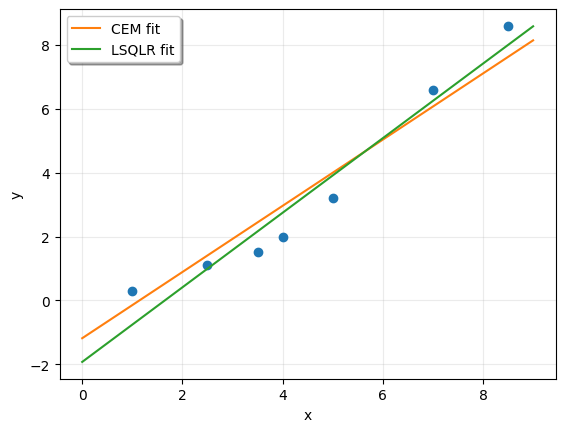

In [11]:
import matplotlib.pyplot as plt
plt.plot(x.reshape(-1), y.reshape(-1), 'o')
xx = np.linspace(0, 9, 101)
plt.plot(xx, means[0] * xx + means[1], label='CEM fit')
lsqlr_a, lsqlr_b = np.polyfit(x.reshape(-1), y.reshape(-1), deg=1) # np.polyfit: least-squares linear regression
plt.plot(xx, lsqlr_a * xx + lsqlr_b, label='LSQLR fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=1, shadow=True)
plt.grid(alpha=0.25)
plt.show()

# Part 2: CEM for linear policy search

Suppose that we have a **reward function** $r: \mathcal{S} \times \mathcal{A} \mapsto [0, 1]$ and a **policy** parameterized by some set of parameters $\theta: \theta \in \Theta$, $\pi_{\theta} : \mathcal{S} \mapsto \mathcal{A}.$

The **reward function** returns the "reward" associated with taking any action $a \in \mathcal{A}$ in any state $s \in \mathcal{S}$ in some environment.


The **policy** is a function that maps environment states (or observations) to actions. A "good" policy is one that maps each state to a "good" action for that state, i.e. one associated with a higher *discounted* reward. An "optimal" policy is the one that maps each state to *the best* action for that state, i.e. the one associated with the highest discounted reward. 

We employ *discounted* rewards rather than *absolute* rewards when evaluating the "goodness" of a policy due to the [temporal credit assignment problem](https://ai.stackexchange.com/questions/12908/what-is-the-credit-assignment-problem), i.e. the phenomenon wherein there may be a state in which taking a certain action is met with *little* **immediate** *reward*, yet is *crucial to ensuring that* **future** *rewards* can be "collected" by the policy. You can read more about credit assignment and discount factors [here](https://en.wikipedia.org/wiki/Q-learning#Discount_factor).

Given some data of the value of the reward function for certain state-action pairs $(s, a) \in \mathcal{S} \times \mathcal{A}$, and/or the ability to query the environment for rewards associated with state-action pairs "online" by "rolling out" the policy, our goal is to find a set of values for our policy parameters $\hat{\theta}$ over the domain $\Theta$ such that $\pi_{\hat{\theta}}$ achieves as total reward as close to the maximum possible discounted reward as possible. This is the basic objective of the **reinforcement learning, or policy search, problem**.


## CEM for cart-pole

In [12]:
! pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


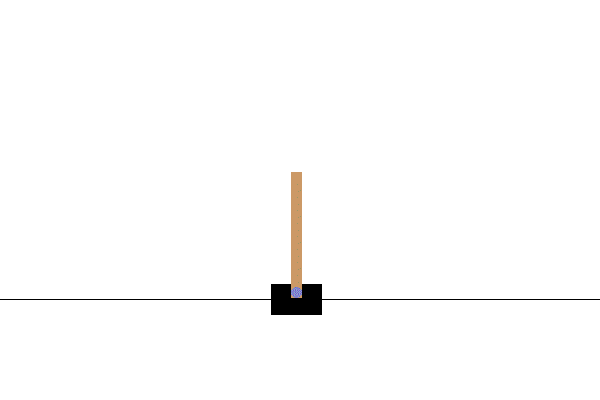

In this part of the tutorial, you'll implement CEM for the cart-pole environment. The cart-pole environment was introduced by reinforcement learning pioneers Barto, Suton, and Anderson in their 1983 seminal paper [Neuronlike adaptive elements that can solve difficult learning control problems](https://ieeexplore.ieee.org/document/6313077). It is a key toy problem for reinforcement learning. A render of this environment is shown above. 

The objective of the cart-pole environment is simple: a pole is attached to a cart with a single hinge, and the goal is to move the cart in such a way as to balance the pole for as long as possible. The *action-space*, i.e. the set of possible actions a policy can take at each time step is also simple: the cart can either be pushed to the right or to the left.

In this exercise, we will be considering the *discrete* version of this environment, where the amount of force we can apply either way is held fixed.

### Observation Space

At each time step of interaction, the environment returns an observation vector in the form of a `numpy.ndarray` with shape `(4,)` and values corresponding to positions and velocities of the cart and pole:

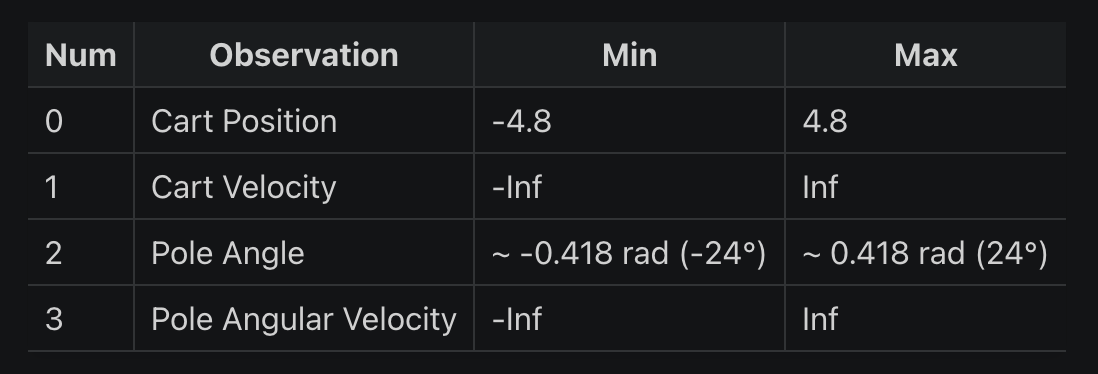

We will formally denote the observation vector as 

\begin{align}
\vec{o}(t) = \begin{bmatrix}
x_{\text{cart}}(t) & 
v_{\text{cart}}(t) & 
\alpha_{\text{pole}}(t) & 
\omega_{\text{pole}}(t)
\end{bmatrix}
\end{align} 

You can examine the actual observation vector returned by the environment via the code block below.

In [13]:
import gym
import logging
logger = logging.getLogger('gym')


env = gym.make('CartPole-v0') # make a new instatiation of the cartpole-v0 environment
ob = env.reset() # reset the enviornment, starting a new episode and yielding `ob(0)`

ob

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


array([ 0.02835235,  0.04891526, -0.02462677,  0.00161788], dtype=float32)

### Action Space

Our policy will take in an observation and transform it into a `numpy.ndarray` with shape `(1,)` and value corresponding to one of our two possible actions:



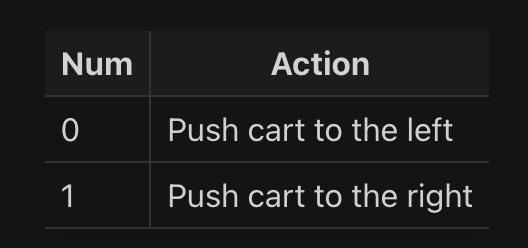

### Rewards

As mentioned above, the goal in this environment is to keep the pole upright for as long as possible up to some maximal number of timesteps. More precisely, an "episode" of interaction will end as soon as one of the following conditions is met:

* (Termination case): the pole angle exceeds $\pm 12^{\circ}$ (i.e. the pole leans too far right or left) and/or the cart position is greater than $\pm 2.4$ (i.e. the center of the cart reaches the end of the display).
* (Truncation case): the episode length exceeds 200 timesteps.

The environment returns a reward of `+1` for each step taken up to the end of the episode.

### Deterministic Linear Policy


Perhaps the simplest way we can imagine trying to solve this task is with a linear policy, i.e. $\theta := [\boldsymbol W, \boldsymbol b]$ where,

\begin{align}
\pi_{\theta}(o(t)) = \text{softmax}\left(o(t) \cdot \boldsymbol W + \boldsymbol b\right) = \begin{bmatrix}
\mathbb{P}[a(t) = 0] & \mathbb{P}[a(t) = 1]
\end{bmatrix}
\end{align}

and $\boldsymbol W \ $ is a `(4, 2)`-shape constant array, $\boldsymbol b \ $ is a `(1, 2)`-shape constant array, and "$\text{softmax}(\cdot)$" denotes the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function), which transforms an arbitrary vector into discrete probability distribution. [Here is a link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html) to the `scipy` implementation of this function. Once we have computed the policy probabilities associated with each action as a function of the observation vector at each timestep, we'll output the action with the highest probability via the [`argmax` function](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

Our goal is to find values for the 2-D array $\boldsymbol W \ $ and  the vector $\boldsymbol b$ that yield a "good" linear policy for cartpole via CEM, i.e. a policy that results in a high total reward across interaction episodes.

### Getting our hands dirty

Let's now implement CEM to determine a deterministic linear policy for cartpole. To start, fill in the missing portions of the policy class.

In [14]:
import gym
import logging
from gym.spaces import Box
from gym.spaces import Discrete
import numpy as np
import scipy
class DeterministicDiscreteActionLinearPolicy(object):
    def __init__(self, theta, ob_space, ac_space):
        """
        dim_ob: dimension of observations
        n_actions: number of actions
        theta: flat vector of parameters
        """
        dim_ob = ob_space.shape[0]
        n_actions = ac_space.n
        assert len(theta) == (dim_ob + 1) * n_actions
        self.W = theta[0 : dim_ob * n_actions].reshape(dim_ob, n_actions)
        self.b = theta[dim_ob * n_actions : None].reshape(1, n_actions)

    def act(self, ob):
        """
        Add in code here which, for an arbitrary observation vector, uses the
        policy attributes self.W and self.b to compute a probability vector over
        the two possible actions, and then return the action with the highest 
        associated probability
        """
        y = ob.dot(self.W) + self.b
        a = scipy.special.softmax(y).argmax()
        return a

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Below is the method's we'll use to "rollout" our policy $\pi_{\theta}$ in the environment, i.e. evaluate its "goodness" by computing total discounted rewards associated with it by interactively collecting data up until an episode ends.

In [15]:
def do_episode(policy, env, discount=1.0):
    """
    Given a `DeterministicDiscreteActionLinearPolicy` policy object, an
    instatiation of the cartpole gym environment, and a value for the discount
    factor, "rollout" an episode of interaction to yield a value for the total
    discounted reward associated with the rollout as well as the episode length
    (i.e. the total number of steps before truncation or termination cases the 
    episode to end).
    """
    disc_total_rew = 0
    ob = env.reset() # reset environment, to start a new episode
    t = 0
    while 1:
        a = policy.act(ob) # get an action from the policy
        (ob, reward, done, _info) = env.step(a) # "step" forward the environment -- i.e., apply the action from the policy at the current timestep, advancing the environment clock by 1
        disc_total_rew += reward * discount ** t # compute the discounted reward via the discount factor
        if done: break # check if the episode has ended
        t += 1 # increment the timestep counter
    return disc_total_rew, t # return the total discounted reward + timestep at episode end (i.e. the episode length)

It's now time for CEM. After tuning the hyperparameters, we get CEM to converge to a Gaussian distribution of parameter values that yields policies which successfully, consistently balance the pole for the maximum number of steps (200 in this case).

In [16]:
import gym
import logging
from gym.spaces import Box
from gym.spaces import Discrete
import numpy as np
from scipy import special

### CEM hyperparameters
n_iter = 20 # number of iterations of CEM
batch_size = 1000 # dimension of each batch
elite_frac = 0.1 # fraction of samples used as elite set
discount = 0.99 # must have value in range [0, 1]
logger = logging.getLogger('gym')
env = gym.make('CartPole-v0') # initialize environment
dim_theta = (env.observation_space.shape[0] + 1) * env.action_space.n # set dimension of the flat vector of parameters, theta

# Initialize mean and standard deviation for multivariate normal
theta_mean = np.zeros(dim_theta)
theta_std = np.ones(dim_theta)

### Main CEM loop
for itr in range(n_iter):
  thetas = np.random.multivariate_normal(mean=theta_mean, 
                                          cov=np.diag((theta_std**2)), 
                                          size=batch_size)
  rewards = []
  balanced_timesteps = []
  for theta in thetas:
    policy = DeterministicDiscreteActionLinearPolicy(theta,
                                                      env.observation_space, 
                                                      env.action_space) ## Initialize policy via `DeterministicDiscreteActionLinearPolicy` class
    reward, ts = do_episode(policy, env, discount=discount) ## Roll out each candidate policy once in the environment
    rewards += [reward]
    balanced_timesteps += [ts]
  rewards = np.array(rewards)
  balanced_timesteps = np.array(balanced_timesteps)

  elite_thetas = thetas[rewards.argsort()[-int(elite_frac * batch_size):]] ## Extract the 'elite' thetas
  theta_mean = elite_thetas.mean(axis=0).reshape(-1) ## Update theta mean
  theta_std = elite_thetas.std(axis=0).reshape(-1)  ## Update theta std

  ## Format and print CEM statistics for the current iteration
  print(', '.join([f'iteration {itr}',
                    f'mean disc reward: {np.mean(rewards)}',
                    f'max disc reward: {np.max(rewards)}',
                    f'mean ts balanced: {np.mean(balanced_timesteps)}']))

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


iteration 0, mean disc reward: 14.542676028681806, max disc reward: 86.6020325142037, mean ts balanced: 16.804
iteration 1, mean disc reward: 28.81464043203641, max disc reward: 86.6020325142037, mean ts balanced: 39.583
iteration 2, mean disc reward: 42.854297285923636, max disc reward: 86.6020325142037, mean ts balanced: 71.004
iteration 3, mean disc reward: 61.607355912982804, max disc reward: 86.6020325142037, mean ts balanced: 120.196
iteration 4, mean disc reward: 70.99119145421692, max disc reward: 86.6020325142037, mean ts balanced: 147.976
iteration 5, mean disc reward: 77.4506318760553, max disc reward: 86.6020325142037, mean ts balanced: 167.264
iteration 6, mean disc reward: 81.0854283795586, max disc reward: 86.6020325142037, mean ts balanced: 178.431
iteration 7, mean disc reward: 82.41484499646872, max disc reward: 86.6020325142037, mean ts balanced: 184.212
iteration 8, mean disc reward: 84.61406805573051, max disc reward: 86.6020325142037, mean ts balanced: 191.619
ite